In [2]:
#!pip install pyspark
#!pip install findspark
import pyspark
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plot
import pandas as pd
import setuptools
from functools import reduce #nulos
from pyspark.sql.types import DoubleType # Utilizado para converter para double

In [3]:
findspark.init()

In [4]:
spark=SparkSession.builder.getOrCreate()
spark

In [58]:
#spark.stop()

## CARTAO - Base Cadastro

In [4]:
## Base Cadastro
df_cad=spark.read.csv("C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base cartões/behavior.csv",header=True,inferSchema=True, sep=";")

# Função para trocar , por . em colunas numéricas
def formatar_col_num(df, colunas):
    for nome_coluna in colunas:
        df = df.withColumn(
            nome_coluna,
            regexp_replace(col(nome_coluna), "\.", "")  
        )
        df = df.withColumn(
            nome_coluna,
            regexp_replace(col(nome_coluna), ",", ".").cast(DoubleType())
        )
    return df

# colunas numéricas
col_numerica=["IDADE",
    "RENDA_DIGITADA",
    "RENDA_VALIDA",
    "TEMPO_RELACIONAMENTO_KREDILIG",
    "TEMPO_INATIVIDADE_KREDILIG",
    "SCORE",
    "LIMITE_TOTAL",
    "LIMITE_A_VISTA",
    "LIMITE_SAQUE",
    "LIMITE_MENSAL",
    "LIMITE_TOTAL_UTILIZADO" ,
    "LIMITE_A_VISTA_UTILIZADO",
    "LIMITE_SAQUE_UTILIZADO",
    "LIMITE_MENSAL_UTILIZADO",
    "LIMITE_TOTAL_DISPONIVEL",
    "LIMITE_A_VISTA_DISPONIVEL",
    "LIMITE_SAQUE_DISPONIVEL",
    "LIMITE_MENSAL_DISPONIVEL"]

df_cad = formatar_col_num(df_cad, col_numerica)

# % de nulos por linha
num_cols_df2=len(df_cad.columns)
cols_to_check = df_cad.columns
df2_com_nulos=df_cad.withColumn("%_nulos",
                             round(reduce(lambda a,b: a+b,
                                      [when(col(c).isNull(),1).otherwise(0) for c in cols_to_check])
                                      / lit(num_cols_df2)*100,4)
                             )

# Excluindo linhas erradas
df_cad_new = df2_com_nulos.filter(
    ~(
        (col("SEXO") == "PF") |
        (col("DATA_MOVIMENTO") == "SC") |
        (col("BLACKLIST") == "Bloqueada") |
        (col("%_nulos")>50) 
    )
).drop("NOME","TIPO_PESSOA","UF_NASCIMENTO","CIDADE_NASCIMENTO","REGIONAL","%_nulos")

#Tipos
tipos = {
    "CPF_CNPJ": "double",
    "IDADE": "int",
    "RENDA_DIGITADA": "double",
    "RENDA_VALIDA": "double",
    "TEMPO_RELACIONAMENTO_KREDILIG": "int",
    "TEMPO_INATIVIDADE_KREDILIG":  "int",
    "SCORE": "double",
    "LIMITE_TOTAL": "double",
    "LIMITE_A_VISTA": "double" ,
    "LIMITE_SAQUE": "double" ,
    "LIMITE_MENSAL": "double" ,
    "LIMITE_TOTAL_UTILIZADO": "double" ,
    "LIMITE_A_VISTA_UTILIZADO": "double" ,
    "LIMITE_SAQUE_UTILIZADO": "double" ,
    "LIMITE_MENSAL_UTILIZADO": "double" ,
    "LIMITE_TOTAL_DISPONIVEL": "double" ,
    "LIMITE_A_VISTA_DISPONIVEL": "double" ,
    "LIMITE_SAQUE_DISPONIVEL": "double" ,
    "LIMITE_MENSAL_DISPONIVEL": "double" 
}

# conversão
for col_nome, tipo in tipos.items():
    df_cad_new = df_cad_new.withColumn(col_nome, col(col_nome).cast(tipo))

# info
df_cad_new.printSchema()
df_cad_new.show()
print(df_cad_new.count())


<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_15280\2393632307.py:9: SyntaxWarning: invalid escape sequence '\.'
  regexp_replace(col(nome_coluna), "\.", "")


root
 |-- ANO_MES_MOVIMENTO: timestamp (nullable = true)
 |-- DATA_MOVIMENTO: string (nullable = true)
 |-- CPF_CNPJ: double (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- IDADE: integer (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- GRAU_ESCOLARIDADE: string (nullable = true)
 |-- NATUREZA_OCUPACAO: string (nullable = true)
 |-- RENDA_DIGITADA: double (nullable = true)
 |-- RENDA_VALIDA: double (nullable = true)
 |-- NACIONALIDADE: string (nullable = true)
 |-- UF_RESIDENCIA: string (nullable = true)
 |-- CIDADE_RESIDENCIA: string (nullable = true)
 |-- FILIAL: string (nullable = true)
 |-- TEMPO_RELACIONAMENTO_KREDILIG: integer (nullable = true)
 |-- TEMPO_INATIVIDADE_KREDILIG: integer (nullable = true)
 |-- BLACKLIST: string (nullable = true)
 |-- DATA_ABERTURA_CONTA: string (nullable = true)
 |-- SITUACAO_CONTA: string (nullable = true)
 |-- MOTIVO_SITUACAO_CONTA: string (nullable = true)
 |-- CANAL_ORIGEM: string (nullable = true)
 |-- NIVEL_DE_RISC

In [ ]:
# tabela de frequencia
col_cat = ['SEXO', 'ESTADO_CIVIL', 'GRAU_ESCOLARIDADE', 'NATUREZA_OCUPACAO', 'NACIONALIDADE', 'UF_RESIDENCIA', 'CIDADE_RESIDENCIA', 'FILIAL', 'BLACKLIST', 'DATA_ABERTURA_CONTA', 'SITUACAO_CONTA', 'MOTIVO_SITUACAO_CONTA', 'CANAL_ORIGEM', 'NIVEL_DE_RISCO', 'ORIGEM_SCORE', 'ORIGEM_ALTERACAO_LIMITE', 'SITUACAO_FATURA', 'HISTORICO_COBRANCA']

# loop
'''for col_nome in col_cat:
    print(f"\n### Frequência para: {col_nome} ###")
    df_cad_new.groupBy(col_nome).count().orderBy("count", ascending=False).show(truncate=False)'''

'for col_nome in col_cat:\n    print(f"\n### Frequência para: {col_nome} ###")\n    df_cad_new.groupBy(col_nome).count().orderBy("count", ascending=False).show(truncate=False)'

In [ ]:
# armazenar as tabelas
tab_freq = {}

for col_nome in col_cat:
    df_freq = df_cad_new.groupBy(col_nome).count().orderBy("count", ascending=False)
    tab_freq[col_nome] = df_freq

# Excel
with pd.ExcelWriter("Ana_Exp_Cadastro_.xlsx", engine="xlsxwriter") as writer:
    for nome, df_spark in tab_freq.items():
        df_cad_new_pandas = df_spark.toPandas() # pandas
        aba = nome[:31] if len(nome) > 31 else nome # para variáveis com nomes grandes, mas não é o caso 
        df_cad_new_pandas.to_excel(writer, sheet_name=aba, index=False)

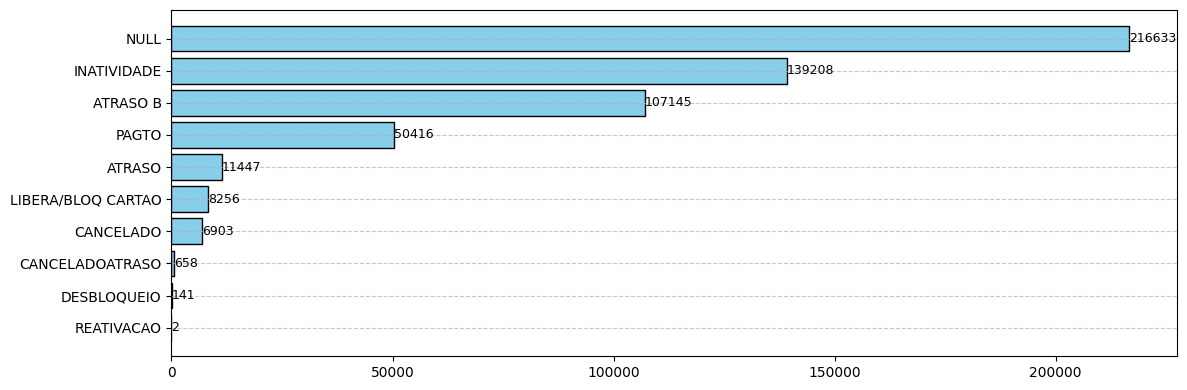

In [ ]:
## Gráfico de Barras

var_counts=tab_freq["MOTIVO_SITUACAO_CONTA"].collect()
var_counts = sorted(var_counts, key=lambda row: row["count"], reverse=True)[:20]  # Top (Variáveis com múltiplas categorias)

plot.figure(figsize=(12, 4))

var=[str(row["MOTIVO_SITUACAO_CONTA"]) if row["MOTIVO_SITUACAO_CONTA"] is not None else "NULL" for row in var_counts]
counts=[row["count"] for row in var_counts]

var = var[::-1]
counts = counts[::-1]

bars = plot.barh(var, counts, color='skyblue', edgecolor='black') # bar(colunas) barh(barras horizontais)
plot.xlabel("Qtd")
plot.xlabel("")
plot.grid(axis='y', linestyle='--', alpha=0.7)

#Rótulos
'''for bar in bars:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                             
        f'{int(height)}',                  
        ha='center', va='bottom', fontsize=9  
    )'''

for bar in bars:
    width = bar.get_width()
    plot.text(
        width,                       
        bar.get_y() + bar.get_height()/2,  
        f'{int(width)}',            
        ha='left', va='center', fontsize=9
    )
plot.tight_layout()
plot.show()

In [ ]:
## Zeros em variáveis numéricas
df_cad_new.select([
    sum((col(c) == 0).cast("int")).alias(c)
    for c in col_numerica
]).show()

+-----+--------------+------------+-----------------------------+--------------------------+-----+------------+--------------+------------+-------------+----------------------+------------------------+----------------------+-----------------------+-----------------------+-------------------------+-----------------------+------------------------+
|IDADE|RENDA_DIGITADA|RENDA_VALIDA|TEMPO_RELACIONAMENTO_KREDILIG|TEMPO_INATIVIDADE_KREDILIG|SCORE|LIMITE_TOTAL|LIMITE_A_VISTA|LIMITE_SAQUE|LIMITE_MENSAL|LIMITE_TOTAL_UTILIZADO|LIMITE_A_VISTA_UTILIZADO|LIMITE_SAQUE_UTILIZADO|LIMITE_MENSAL_UTILIZADO|LIMITE_TOTAL_DISPONIVEL|LIMITE_A_VISTA_DISPONIVEL|LIMITE_SAQUE_DISPONIVEL|LIMITE_MENSAL_DISPONIVEL|
+-----+--------------+------------+-----------------------------+--------------------------+-----+------------+--------------+------------+-------------+----------------------+------------------------+----------------------+-----------------------+-----------------------+-------------------------+------

In [ ]:
df_cad_new.filter((col("TEMPO_RELACIONAMENTO_KREDILIG")<180)).count() # Categorizar novos associados

33886

In [61]:
df_cad_new.filter(
    (col("CPF_CNPJ")=="5355531962")|
    (col("CPF_CNPJ")=="24434489836")|
    (col("CPF_CNPJ")=="9597228904")             
    ).show(200,truncate=False) # Categorizar novos associados

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\fernando.monteiro\deep-torch-example\.venv\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\.venv\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\fernando.monteiro\AppData\Local\Programs\Python\Python312\Lib\socket.py", line 708, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
df_cad_new.filter(
    (col("LIMITE_TOTAL_UTILIZADO")<0)|
    (col("LIMITE_A_VISTA_UTILIZADO")<0)|
    (col("LIMITE_MENSAL_UTILIZADO")<0) |
    (col("LIMITE_SAQUE_UTILIZADO")<0) | 
    (col("LIMITE_TOTAL_DISPONIVEL")<0) |  
    (col("LIMITE_A_VISTA_DISPONIVEL")<0) |  
    (col("LIMITE_SAQUE_DISPONIVEL")<0) |       
    (col("LIMITE_MENSAL_DISPONIVEL")<0) 
    ).count() # Categorizar novos associados

94851

In [ ]:
'''## Funções de agregação mean, min, max, median, count, countDistinct,stddev
df_cad_new.agg(min("TEMPO_RELACIONAMENTO_KREDILIG").alias("Mínimo"),\
            median("TEMPO_RELACIONAMENTO_KREDILIG").alias("Mediana"),\
            max("TEMPO_RELACIONAMENTO_KREDILIG").alias("Máximo"),\
            mean("TEMPO_RELACIONAMENTO_KREDILIG").alias("Média"),\
            stddev("TEMPO_RELACIONAMENTO_KREDILIG").alias("Desvio Padrão"),\
            count('TEMPO_RELACIONAMENTO_KREDILIG').alias("Qtd")
            ).show(truncate=False)## Toda a variável'''

+------+-------+------+------------------+-----------------+------+
|Mínimo|Mediana|Máximo|Média             |Desvio Padrão    |Qtd   |
+------+-------+------+------------------+-----------------+------+
|0     |1577.0 |3667  |1599.5925234232418|992.2202586520292|540809|
+------+-------+------+------------------+-----------------+------+



In [7]:
# Medidas descritivas

resultados = []
for coluna in col_numerica:
    resumo= df_cad_new.agg(
        min(col(coluna)).alias("Mínimo"),
        expr(f"percentile_approx({coluna}, 0.25)").alias("1 Quartil"),
        expr(f"percentile_approx({coluna}, 0.5)").alias("Mediana"),
        expr(f"percentile_approx({coluna}, 0.75)").alias("3 Quartil"),
        max(col(coluna)).alias("Máximo"),
        round(mean(col(coluna)),4).alias("Média"),
        round(stddev(col(coluna)),4).alias("Desvio Padrão"),
        round((stddev(col(coluna))/mean(col(coluna)))*100,4).alias("CV (%)"),
        count(col(coluna)).alias("Qtd")
        ).withColumn("Variável", lit(coluna))
    resultados.append(resumo)

df_resumo = resultados[0]
for r in resultados[1:]:
    df_resumo = df_resumo.union(r)

df_resumo.show()

'''df_resumo_pd = df_resumo.toPandas()
df_resumo_pd.to_excel("medidas_descritivas_Cad.xlsx", index=False)'''

+----------+---------+-------+---------+-------------+----------+-------------+---------+------+--------------------+
|    Mínimo|1 Quartil|Mediana|3 Quartil|       Máximo|     Média|Desvio Padrão|   CV (%)|   Qtd|            Variável|
+----------+---------+-------+---------+-------------+----------+-------------+---------+------+--------------------+
|      18.0|     37.0|   50.0|     63.0|        106.0|   50.4294|      16.3218|  32.3656|540809|               IDADE|
|      0.01|   1700.0| 2471.0|   3500.0|1.920014537E8| 3438.9688|   263991.167|7676.4629|540809|      RENDA_DIGITADA|
|       0.0|      0.0|    0.0|      0.0|    2611128.0|19729.0404|   66876.3968| 338.9744|540809|        RENDA_VALIDA|
|       0.0|    704.0| 1576.0|   2407.0|       3667.0| 1599.5925|     992.2203|  62.0296|540809|TEMPO_RELACIONAME...|
|       0.0|     12.0|   72.0|    602.0|       3549.0|  385.0013|     585.2222| 152.0052|540809|TEMPO_INATIVIDADE...|
|       0.0|    723.0|  877.0|    959.0|       1000.0|  

'df_resumo_pd = df_resumo.toPandas()\ndf_resumo_pd.to_excel("medidas_descritivas_Cad.xlsx", index=False)'

In [62]:
coluna = "LIMITE_MENSAL_DISPONIVEL"

# Histograma 
df_cad_pandas = df_cad_new.toPandas()

# histograma
plot.hist(df_cad_pandas[coluna],alpha=0.8, color='blue',edgecolor='black')
plot.xlabel("Variável")
plot.ylabel("Frequência")
plot.title("Histograma")
plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', axis='both')
plot.show()

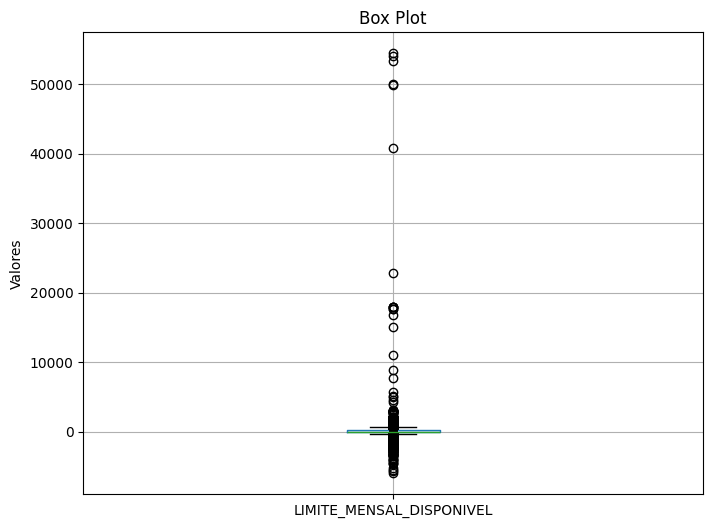

In [ ]:
# boxplot
df_cad_pandas.boxplot(column=coluna, figsize=(8, 6))
plot.title('Box Plot')
plot.ylabel('Valores')
plot.show()

In [ ]:
# Identificando outiliers

quantis = df_cad_new.approxQuantile(coluna, [0.25, 0.75], 0.0)
Q1, Q3 = quantis
IQR = Q3 - Q1

LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR

outliers = df_cad_new.filter((col(coluna) < LI) | (col(coluna) > LS))
print("Outliers")
outliers.orderBy(coluna, ascending=False).count()

Outliers


47344

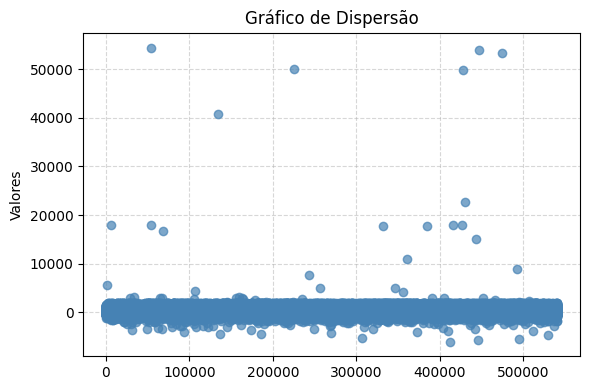

In [ ]:
# Gráfico de dispersão
df_plot = df_cad_new.select(coluna).dropna().toPandas()

plot.figure(figsize=(6, 4))
plot.plot(df_plot[coluna], 'o', color='steelblue', alpha=0.7)
plot.ylabel("Valores")
plot.title("Gráfico de Dispersão")
plot.grid(True, linestyle='--', alpha=0.5)
plot.tight_layout()
plot.show()

In [ ]:
# Tabela de contingência

## Contatos Carnê

In [8]:
# Base Carnê
df_carne=spark.read.csv("C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos Carne/banco de dados/contratos_carne.csv",sep=";", header=True, inferSchema=True)

# % de nulos por linha
df_carne=df_carne.withColumn("%_nulos",
                             round(reduce(lambda a,b: a+b,
                                      [when(col(c).isNull(),1).otherwise(0) for c in df_carne.columns])
                                      / lit(len(df_carne.columns))*100,4)
                             )

# Excluindo Espaços em branco à esquerda e direita
df_carne=df_carne.withColumn('id_agente', trim(col('id_agente')))

# Excluindo linhas
df_carne = df_carne.filter(
    ~(
        (col("id_agente") == "033 VENDAS ATACADO") |
        (col("id_agente") == "009 SAQUE EMERGENCIAL")|
        (col("id_agente") == "029 RENEGOCIACAO SAQUE EMER (AG19)")|
        (col("id_agente") == "019 RENEGOCIACAO SAQUE EMERGENCIAL")|
        (col("%_nulos")>50)
        )
        ).drop("%_nulos")

#Tipos
tipos_carne = {
    "cpf_cnpj": "string",
    "conceito": "string",
    "id_contrato": "string",
    "id_financeira": "string",
    "data": "date",
    "media_atraso":  "double",
    "data_vencimento_prox_parcela": "date",
    "data_vencimento_ultima_parcela": "date"}

# conversão
for col_nome, tipo in tipos_carne.items():
    df_carne = df_carne.withColumn(col_nome, col(col_nome).cast(tipo))


# Categorização
df_carne = df_carne.withColumn(
    "Produto",
    when(col("id_agente").isin("001 CREDIARIO", "011 RENEGOCIACAO CREDIARIO", "021 RENEGOCIACAO CREDIARIO (AG 11)"), "CREDIARIO")
    .when(col("id_agente").isin("004 KREDILIG (CDC)", "014 RENEGOCIACAO CDC","024 RENEGOCIACAO CDC (AG 14)"), "CDC")
    .when(col("id_agente").isin("005 KREDILIG (CP)", "015 RENEGOCIACAO CP","025 RENEGOCIACAO CP (AG 15)"), "CP")
    .when(col("id_agente").isin("044 SEGURO - KREDILIG (CDC)"), "CDC")
    .otherwise("SEM CLASSIFICACAO")
)

# Criar novas variáveis, resumir

cols_a_vencer = [
    "creditos_a_vencer_ate_30_dias",
    "creditos_a_vencer_de_31_e_60_dias",
    "creditos_a_vencer_de_61_e_90_dias",
    "creditos_a_vencer_de_91_e_180_dias",
    "creditos_a_vencer_de_181_e_360_dias",
    "creditos_a_vencer_de_361_e_720_dias",
    "creditos_a_vencer_de_721_e_1080_dias",
    "creditos_a_vencer_de_1081_e_1440_dias",
    "creditos_a_vencer_de_1441_e_1800_dias",
    "creditos_a_vencer_de_1801_e_5400_dias",
    "creditos_a_vencer_acima_de_5400_dias"
]

cols_vencidos = [
    "creditos_vencidos_de_1_a_14_dias",
    "creditos_vencidos_de_15_a_30_dias",
    "creditos_vencidos_de_31_a_60_dias",
    "creditos_vencidos_de_61_a_90_dias",
    "creditos_vencidos_de_91_a_120_dias",
    "creditos_vencidos_de_121_a_150_dias",
    "creditos_vencidos_de_151_a_180_dias",
    "creditos_vencidos_de_181_a_240_dias",
    "creditos_vencidos_de_241_a_300_dias",
    "creditos_vencidos_de_301_a_360_dias",
    "creditos_vencidos_de_361_a_540_dias",
    "creditos_vencidos_acima_de_540_dias"
]

df_carne = (
    df_carne
    .withColumn("Creditos_a_vencer", reduce(lambda a, b: a + b, [col(c) for c in cols_a_vencer])) # soma das colunas crédito a vencer
    .withColumn("creditos_vencidos", reduce(lambda a, b: a + b, [col(c) for c in cols_vencidos])) # soma das colunas crédito vencidos
    .withColumn("ind_reneg", when(col("flag_renegociacao").isin("SIM"), 1).otherwise(0)) # Indicador numérico de contratos de Renegociação
    .withColumn("inad_60_aberto", when(col("dias_maior_atraso_aberto")>60, 1).otherwise(0)) # Idicador 1 se o contrato tem mais de 60 dias em atraso e 0 caso contrário
    .withColumn("inad_60", when(col("dias_maior_atraso")>60, 1).otherwise(0)) # Idicador 1 se o contrato teve mais de 60 dias em atraso e 0 caso contrário
    .drop(*cols_a_vencer, *cols_vencidos) 
)

# variáveis numéricas
tipos_num = ['int', 'bigint', 'double', 'float', 'decimal']

col_num_carne = [nome for nome, tipo in df_carne.dtypes if any(t in tipo for t in tipos_num)]


# info
df_carne.printSchema()
df_carne.show()
print(df_carne.count())

root
 |-- anomes: string (nullable = true)
 |-- cpf_cnpj: string (nullable = true)
 |-- conceito: string (nullable = true)
 |-- id_contrato: string (nullable = true)
 |-- id_financeira: string (nullable = true)
 |-- data: date (nullable = true)
 |-- id_agente: string (nullable = true)
 |-- dias_carencia: integer (nullable = true)
 |-- taxajuros: double (nullable = true)
 |-- cet: double (nullable = true)
 |-- saldo_contabil: double (nullable = true)
 |-- dias_maior_atraso: integer (nullable = true)
 |-- dias_maior_atraso_aberto: integer (nullable = true)
 |-- media_atraso: double (nullable = true)
 |-- qtd_parcelas: integer (nullable = true)
 |-- qtd_parcelas_abertas: integer (nullable = true)
 |-- qtd_parcelas_pagas: integer (nullable = true)
 |-- valor_entrada: double (nullable = true)
 |-- valor_pago: double (nullable = true)
 |-- valor_pago_atraso: double (nullable = true)
 |-- valor_parcela: string (nullable = true)
 |-- data_vencimento_prox_parcela: date (nullable = true)
 |-- da

In [ ]:
'''# Qtd de contratos por Cpf
res = df_carne_join.groupBy("cpf_cnpj").agg(count("id_contrato").alias("num_id_contrato"),
                                 max("dias_maior_atraso_aberto").alias("id_inad")) 
res.show()
res.filter((col("num_id_contrato") > 10) &
           (col("id_inad") > 1)).show()'''

In [9]:
df_carne.groupBy("Produto").count().show(truncate=False)

+---------+------+
|Produto  |count |
+---------+------+
|CDC      |427018|
|CP       |309084|
|CREDIARIO|786895|
+---------+------+



In [7]:
# tabela de frequencia
col_cat_carne = ["flag_renegociacao", "conceito","id_agente", "Produto"]

# armazenar as tabelas
tab_freq_carne = {}

for col_nome in col_cat_carne:
    df_freq = df_carne.groupBy(col_nome).count().orderBy("count", ascending=False)
    tab_freq_carne[col_nome] = df_freq

# Excel
with pd.ExcelWriter("Ana_Exp_Carne_.xlsx", engine="xlsxwriter") as writer:
    for nome, df_spark in tab_freq_carne.items():
        df_carne_new_pandas = df_spark.toPandas() # pandas
        aba = nome[:31] if len(nome) > 31 else nome # para variáveis com nomes grandes, mas não é o caso 
        df_carne_new_pandas.to_excel(writer, sheet_name=aba, index=False)

In [ ]:
'''
# Conceito distintos para o mesmo Cpf
df_carne_join.groupBy("cpf_cnpj").agg(countDistinct("conceito").alias("Conceito_dist")).filter((col("Conceito_dist") > 1)).show()
df_carne_join.filter(## cpf possui dois conceitos diferentes
    col("cpf_cnpj")==3.4946861068E10            
    ).show()
    '''

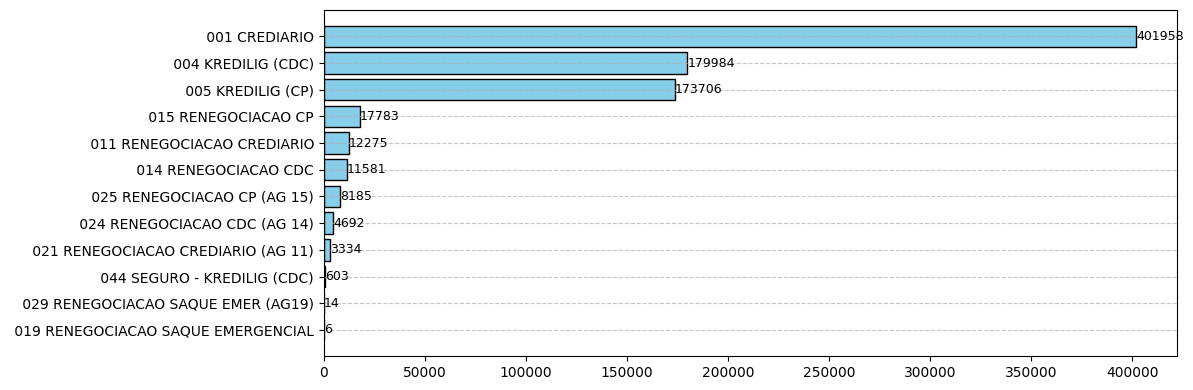

In [ ]:
## Gráfico de Barras

var_cat= "id_agente"

var_counts=tab_freq_carne[var_cat].collect()
var_counts = sorted(var_counts, key=lambda row: row["count"], reverse=True)[:20]  # Top (Variáveis com múltiplas categorias)

plot.figure(figsize=(12, 4))

var=[str(row[var_cat]) if row[var_cat] is not None else "NULL" for row in var_counts]
counts=[row["count"] for row in var_counts]

var = var[::-1]
counts = counts[::-1]

bars = plot.barh(var, counts, color='skyblue', edgecolor='black') # bar(colunas) barh(barras horizontais)
plot.xlabel("Qtd")
plot.xlabel("")
plot.grid(axis='y', linestyle='--', alpha=0.7)

#Rótulos
'''for bar in bars:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                             
        f'{int(height)}',                  
        ha='center', va='bottom', fontsize=9  
    )'''

for bar in bars:
    width = bar.get_width()
    plot.text(
        width,                       
        bar.get_y() + bar.get_height()/2,  
        f'{int(width)}',            
        ha='left', va='center', fontsize=9
    )
plot.tight_layout()
plot.show()

In [10]:
## Zeros em variáveis numéricas
col_num_carne_2=['dias_carencia',
 'taxajuros',
 'cet',
 'saldo_contabil',
 'dias_maior_atraso',
 'dias_maior_atraso_aberto',
 'media_atraso',
 'qtd_parcelas',
 'qtd_parcelas_abertas',
 'qtd_parcelas_pagas',
 'valor_entrada',
 'valor_pago',
 'valor_pago_atraso',
 'valor_parcela',
 'principal_total',
 'servicos_financeiros',
 'Creditos_a_vencer',
 'creditos_vencidos']


'''df_carne_join.select([
    sum((col(c) == 0).cast("int")).alias(c)
    for c in col_num_carne_2
]).show()'''


'df_carne_join.select([\n    sum((col(c) == 0).cast("int")).alias(c)\n    for c in col_num_carne_2\n]).show()'

In [ ]:
df_carne.filter(
    (col("saldo_contabil")==0)           
    ).show(20,truncate=False) # Categorizar novos associados

+-------+------------+--------+-----------+-------------+----------+---------------------------+-------------+---------+-----+--------------+-----------------+------------------------+------------+------------+--------------------+------------------+-------------+----------+-----------------+-------------+----------------------------+------------------------------+---------------+--------------------+-----------------+---------+-----------------+-----------------+---------+--------------+-------+------------+
|anomes |cpf_cnpj    |conceito|id_contrato|id_financeira|data      |id_agente                  |dias_carencia|taxajuros|cet  |saldo_contabil|dias_maior_atraso|dias_maior_atraso_aberto|media_atraso|qtd_parcelas|qtd_parcelas_abertas|qtd_parcelas_pagas|valor_entrada|valor_pago|valor_pago_atraso|valor_parcela|data_vencimento_prox_parcela|data_vencimento_ultima_parcela|principal_total|servicos_financeiros|flag_renegociacao|Produto  |Creditos_a_vencer|creditos_vencidos|ind_reneg|inad_60

In [12]:
# Medidas descritivas

resultados = []
for coluna in col_num_carne_2:
    resumo= df_carne.groupBy(col("id_agente")).agg(
        min(col(coluna)).alias("Mínimo"),
        expr(f"percentile_approx({coluna}, 0.25)").alias("1 Quartil"),
        expr(f"percentile_approx({coluna}, 0.5)").alias("Mediana"),
        expr(f"percentile_approx({coluna}, 0.75)").alias("3 Quartil"),
        max(col(coluna)).alias("Máximo"),
        round(mean(col(coluna)),4).alias("Média"),
        round(stddev(col(coluna)),4).alias("Desvio Padrão"),
        round((stddev(col(coluna))/mean(col(coluna)))*100,4).alias("CV (%)"),
        count(col(coluna)).alias("Qtd")
        ).withColumn("Variável", lit(coluna))
    resultados.append(resumo)

df_resumo = resultados[0]
for r in resultados[1:]:
    df_resumo = df_resumo.union(r)

df_resumo.show()

+--------------------+------+---------+-------+---------+------+-------+-------------+---------+------+-------------+
|           id_agente|Mínimo|1 Quartil|Mediana|3 Quartil|Máximo|  Média|Desvio Padrão|   CV (%)|   Qtd|     Variável|
+--------------------+------+---------+-------+---------+------+-------+-------------+---------+------+-------------+
|       001 CREDIARIO|   0.0|     30.0|   31.0|     34.0| 138.0|30.3244|      20.5657|  67.8189|743328|dias_carencia|
|  004 KREDILIG (CDC)|   0.0|     30.0|   34.0|     92.0| 125.0|48.7244|      35.0233|  71.8804|383220|dias_carencia|
|011 RENEGOCIACAO ...|   0.0|      0.0|    0.0|      0.0|  75.0| 0.3996|       4.9206|1231.3712| 29034|dias_carencia|
|021 RENEGOCIACAO ...|   0.0|      0.0|    0.0|      0.0|  65.0| 0.1143|       2.6495|2318.1781| 14533|dias_carencia|
|014 RENEGOCIACAO CDC|   0.0|      0.0|    0.0|      0.0|  82.0| 0.8067|        7.013| 869.3134| 28147|dias_carencia|
|025 RENEGOCIACAO ...|   0.0|      0.0|    0.0|      0.0

'df_resumo_pd = df_resumo.toPandas()\ndf_resumo_pd.to_excel("medidas_descritivas_Carne.xlsx", index=False)'

In [13]:
df_resumo_pd = df_resumo.toPandas()
df_resumo_pd.to_excel("medidas_descritivas_Carne.xlsx", index=False)

In [14]:
df_carne.groupBy(col("Produto")).count().show(truncate=False)

+---------+------+
|Produto  |count |
+---------+------+
|CDC      |427018|
|CP       |309084|
|CREDIARIO|786895|
+---------+------+



In [15]:
df_carne=df_carne.orderBy(asc("Produto"),desc("cpf_cnpj"), asc("data"))
df_carne.show()

+-------+-----------+--------+-----------+-------------+----------+--------------------+-------------+---------+----+--------------+-----------------+------------------------+------------+------------+--------------------+------------------+-------------+----------+-----------------+-------------+----------------------------+------------------------------+---------------+--------------------+-----------------+-------+-----------------+------------------+---------+--------------+-------+
| anomes|   cpf_cnpj|conceito|id_contrato|id_financeira|      data|           id_agente|dias_carencia|taxajuros| cet|saldo_contabil|dias_maior_atraso|dias_maior_atraso_aberto|media_atraso|qtd_parcelas|qtd_parcelas_abertas|qtd_parcelas_pagas|valor_entrada|valor_pago|valor_pago_atraso|valor_parcela|data_vencimento_prox_parcela|data_vencimento_ultima_parcela|principal_total|servicos_financeiros|flag_renegociacao|Produto|Creditos_a_vencer| creditos_vencidos|ind_reneg|inad_60_aberto|inad_60|
+-------+-------

In [16]:
## Zeros em variáveis numéricas

df_carne.select([
    sum((col(c) == 0).cast("int")).alias(c)
    for c in col_num_carne
]).show()

+-------------+---------+------+--------------+-----------------+------------------------+------------+------------+--------------------+------------------+-------------+----------+-----------------+---------------+--------------------+-----------------+-----------------+---------+--------------+-------+
|dias_carencia|taxajuros|   cet|saldo_contabil|dias_maior_atraso|dias_maior_atraso_aberto|media_atraso|qtd_parcelas|qtd_parcelas_abertas|qtd_parcelas_pagas|valor_entrada|valor_pago|valor_pago_atraso|principal_total|servicos_financeiros|Creditos_a_vencer|creditos_vencidos|ind_reneg|inad_60_aberto|inad_60|
+-------------+---------+------+--------------+-----------------+------------------------+------------+------------+--------------------+------------------+-------------+----------+-----------------+---------------+--------------------+-----------------+-----------------+---------+--------------+-------+
|       306864|   120401|120397|       1180958|           477256|                 

In [18]:
casos_negativos=df_carne.filter(
    (col("taxajuros")<0) |
    (col("cet")<0) |
    (col("qtd_parcelas_pagas")<0) |
    (col("principal_total")<0)
    )

casos_negativos = casos_negativos.toPandas() # pandas
casos_negativos.to_excel("casos_negativos.xlsx", index=False)

In [19]:
df_carne.printSchema()

root
 |-- anomes: string (nullable = true)
 |-- cpf_cnpj: string (nullable = true)
 |-- conceito: string (nullable = true)
 |-- id_contrato: string (nullable = true)
 |-- id_financeira: string (nullable = true)
 |-- data: date (nullable = true)
 |-- id_agente: string (nullable = true)
 |-- dias_carencia: integer (nullable = true)
 |-- taxajuros: double (nullable = true)
 |-- cet: double (nullable = true)
 |-- saldo_contabil: double (nullable = true)
 |-- dias_maior_atraso: integer (nullable = true)
 |-- dias_maior_atraso_aberto: integer (nullable = true)
 |-- media_atraso: double (nullable = true)
 |-- qtd_parcelas: integer (nullable = true)
 |-- qtd_parcelas_abertas: integer (nullable = true)
 |-- qtd_parcelas_pagas: integer (nullable = true)
 |-- valor_entrada: double (nullable = true)
 |-- valor_pago: double (nullable = true)
 |-- valor_pago_atraso: double (nullable = true)
 |-- valor_parcela: string (nullable = true)
 |-- data_vencimento_prox_parcela: date (nullable = true)
 |-- da

## Contratos Cartão

In [4]:
## Base cartões 

arquivos_cartao = [
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2015.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2016.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2017.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2018.csv",    
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2019.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2020.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2021.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2022.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2023.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2024.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2025.csv"]

df_cartao = spark.read.csv(arquivos_cartao,sep=";", header=True, inferSchema=True)

In [5]:
# Função para trocar , por . em colunas numéricas
def formatar_col_num(df, colunas):
    for nome_coluna in colunas:
        df = df.withColumn(
            nome_coluna,
            regexp_replace(col(nome_coluna), r"\.", "")  
        )
        df = df.withColumn(
            nome_coluna,
            regexp_replace(col(nome_coluna), ",", ".").cast(DoubleType())
        )
    return df

In [6]:
# colunas numéricas
col_numerica_cartao=["DIAS_CARENCIA",
"TAXA_JUROS",
"CET",
"SALDO_CONTABIL",
"DIAS_MAIOR_ATRASO_ABERTO",
"DIAS_MAIOR_ATRASO",
"MEDIA_ATRASO",
"QTD_PARCELAS",
"QTD_PARCELAS_ABERTAS",
"QTD_PARCELAS_PAGAS",
"VALOR_PAGO",
"JUROS_PAGOS_ATRASO",
"VALOR_PARCELA",
"VALOR_CALCULADO",
"VALOR_DESCONTO",
"PRINCIPAL_TOTAL",
"VALOR_FINANCIADO",
"CREDITOS_A_VENCER_ATE_30_DIAS",
"CREDITOS_A_VENCER_DE_31_A_60_DIAS",
"CREDITOS_A_VENCER_DE_61_A_90_DIAS",
"CREDITOS_A_VENCER_DE_91_A_180_DIAS",
"CREDITOS_A_VENCER_DE_181_A_360_DIAS",
"CREDITOS_A_VENCER_DE_361_A_720_DIAS",
"CREDITOS_A_VENCER_DE_721_A_1080_DIAS",
"CREDITOS_A_VENCER_DE_1081_A_1440_DIAS",
"CREDITOS_A_VENCER_DE_1441_A_1800_DIAS",
"CREDITOS_A_VENCER_DE_1801_A_5400_DIAS",
"CREDITOS_A_VENCER_ACIMA_DE_5400_DIAS",
"CREDITOS_VENCIDOS_DE_1_A_14_DIAS",
"CREDITOS_VENCIDOS_DE_15_A_30_DIAS",
"CREDITOS_VENCIDOS_DE_31_A_60_DIAS",
"CREDITOS_VENCIDOS_DE_61_A_90_DIAS",
"CREDITOS_VENCIDOS_DE_91_A_120_DIAS",
"CREDITOS_VENCIDOS_DE_121_A_150_DIAS",
"CREDITOS_VENCIDOS_DE_151_A_180_DIAS",
"CREDITOS_VENCIDOS_DE_181_A_240_DIAS",
"CREDITOS_VENCIDOS_DE_241_A_300_DIAS",
"CREDITOS_VENCIDOS_DE_301_A_360_DIAS",
"CREDITOS_VENCIDOS_DE_361_A_540_DIAS",
"CREDITOS_VENCIDOS_ACIMA_DE_540_DIAS"]

df_cartao = formatar_col_num(df_cartao, col_numerica_cartao)

In [7]:
# % de nulos por linha
df_cartao=df_cartao.withColumn("%_nulos",
                             round(reduce(lambda a,b: a+b,
                                      [when(col(c).isNull(),1).otherwise(0) for c in df_cartao.columns])
                                      / lit(len(df_cartao.columns))*100,4)
)

In [8]:
# Excluindo linhas com mais de 50% de nulos
df_cartao = df_cartao.filter(
    ~(
        (col("%_nulos")>50) 
        )
        ).drop("%_nulos")

In [9]:
#Tipos
tipos_cartao = {
    "DIAS_CARENCIA": "integer",
    "DIAS_MAIOR_ATRASO_ABERTO": "integer",
    "DIAS_MAIOR_ATRASO": "integer", 
    "QTD_PARCELAS": "integer", 
    "QTD_PARCELAS_ABERTAS": "integer", 
    "QTD_PARCELAS_PAGAS":"integer"}

# conversão
for col_nome, tipo in tipos_cartao.items():
    df_cartao = df_cartao.withColumn(col_nome, col(col_nome).cast(tipo))

In [10]:
# Criar novas variáveis, resumir

cols_a_vencer_cartao = [
   "CREDITOS_A_VENCER_ATE_30_DIAS",
"CREDITOS_A_VENCER_DE_31_A_60_DIAS",
"CREDITOS_A_VENCER_DE_61_A_90_DIAS",
"CREDITOS_A_VENCER_DE_91_A_180_DIAS",
"CREDITOS_A_VENCER_DE_181_A_360_DIAS",
"CREDITOS_A_VENCER_DE_361_A_720_DIAS",
"CREDITOS_A_VENCER_DE_721_A_1080_DIAS",
"CREDITOS_A_VENCER_DE_1081_A_1440_DIAS",
"CREDITOS_A_VENCER_DE_1441_A_1800_DIAS",
"CREDITOS_A_VENCER_DE_1801_A_5400_DIAS",
"CREDITOS_A_VENCER_ACIMA_DE_5400_DIAS",

]

cols_vencidos_cartao = [
    "CREDITOS_VENCIDOS_DE_1_A_14_DIAS",
"CREDITOS_VENCIDOS_DE_15_A_30_DIAS",
"CREDITOS_VENCIDOS_DE_31_A_60_DIAS",
"CREDITOS_VENCIDOS_DE_61_A_90_DIAS",
"CREDITOS_VENCIDOS_DE_91_A_120_DIAS",
"CREDITOS_VENCIDOS_DE_121_A_150_DIAS",
"CREDITOS_VENCIDOS_DE_151_A_180_DIAS",
"CREDITOS_VENCIDOS_DE_181_A_240_DIAS",
"CREDITOS_VENCIDOS_DE_241_A_300_DIAS",
"CREDITOS_VENCIDOS_DE_301_A_360_DIAS",
"CREDITOS_VENCIDOS_DE_361_A_540_DIAS",
"CREDITOS_VENCIDOS_ACIMA_DE_540_DIAS"
]

df_cartao = (
    df_cartao
    .withColumn("Creditos_a_vencer", reduce(lambda a, b: a + b, [col(c) for c in cols_a_vencer_cartao])) # soma das colunas crédito a vencer
    .withColumn("creditos_vencidos", reduce(lambda a, b: a + b, [col(c) for c in cols_vencidos_cartao])) # soma das colunas crédito vencidos
    .withColumn("DATA_CONTRATO", to_date("DATA_CONTRATO","dd/MM/yyyy"))
    .withColumn("DATA_VENCIMENTO_PROX_PARCELA", to_date("DATA_VENCIMENTO_PROX_PARCELA","dd/MM/yyyy"))
    .withColumn("DATA_VENCIMENTO_ULTIMA_PARCELA",to_date("DATA_VENCIMENTO_ULTIMA_PARCELA","dd/MM/yyyy"))
    .drop(*cols_a_vencer_cartao, *cols_vencidos_cartao,'_c48') 
)

In [11]:
# variáveis numéricas
tipos_num = ['int', 'bigint', 'double', 'float', 'decimal']

col_num_cartao = [nome for nome, tipo in df_cartao.dtypes if any(t in tipo for t in tipos_num)]

# info
df_cartao.printSchema()

root
 |-- ANO_MES_MOVIMENTO: timestamp (nullable = true)
 |-- CPF_CNPJ: double (nullable = true)
 |-- NUMERO_CONTRATO: integer (nullable = true)
 |-- DATA_CONTRATO: date (nullable = true)
 |-- MODALIDADE: integer (nullable = true)
 |-- DIAS_CARENCIA: integer (nullable = true)
 |-- TAXA_JUROS: double (nullable = true)
 |-- CET: double (nullable = true)
 |-- SALDO_CONTABIL: double (nullable = true)
 |-- DIAS_MAIOR_ATRASO_ABERTO: integer (nullable = true)
 |-- DIAS_MAIOR_ATRASO: integer (nullable = true)
 |-- MEDIA_ATRASO: double (nullable = true)
 |-- QTD_PARCELAS: integer (nullable = true)
 |-- QTD_PARCELAS_ABERTAS: integer (nullable = true)
 |-- QTD_PARCELAS_PAGAS: integer (nullable = true)
 |-- VALOR_PAGO: double (nullable = true)
 |-- JUROS_PAGOS_ATRASO: double (nullable = true)
 |-- VALOR_PARCELA: double (nullable = true)
 |-- DATA_VENCIMENTO_PROX_PARCELA: date (nullable = true)
 |-- DATA_VENCIMENTO_ULTIMA_PARCELA: date (nullable = true)
 |-- VALOR_CALCULADO: double (nullable = true

In [32]:
df_cartao.show()

+-------------------+---------------+---------------+-------------+----------+-------------+----------+------+--------------+------------------------+-----------------+------------+------------+--------------------+------------------+----------+------------------+-------------+----------------------------+------------------------------+---------------+--------------+---------------+----------------+-----------------+-----------------+-----------------+
|  ANO_MES_MOVIMENTO|       CPF_CNPJ|NUMERO_CONTRATO|DATA_CONTRATO|MODALIDADE|DIAS_CARENCIA|TAXA_JUROS|   CET|SALDO_CONTABIL|DIAS_MAIOR_ATRASO_ABERTO|DIAS_MAIOR_ATRASO|MEDIA_ATRASO|QTD_PARCELAS|QTD_PARCELAS_ABERTAS|QTD_PARCELAS_PAGAS|VALOR_PAGO|JUROS_PAGOS_ATRASO|VALOR_PARCELA|DATA_VENCIMENTO_PROX_PARCELA|DATA_VENCIMENTO_ULTIMA_PARCELA|VALOR_CALCULADO|VALOR_DESCONTO|PRINCIPAL_TOTAL|VALOR_FINANCIADO|FLAG_RENEGOCIACAO|Creditos_a_vencer|creditos_vencidos|
+-------------------+---------------+---------------+-------------+----------+--------

In [33]:
print(df_cartao.count())

2292529


In [ ]:
# tabela de frequencia
col_cat_cartao = ["FLAG_RENEGOCIACAO", "MODALIDADE"]

# armazenar as tabelas
tab_freq_cartao = {}

for col_nome in col_cat_cartao:
    df_freq = df_cartao.groupBy(col_nome).count().orderBy("count", ascending=False)
    tab_freq_cartao[col_nome] = df_freq

for col_nome, df_freq in tab_freq_cartao.items():
    print(f"Tabela de frequência para {col_nome}:")
    df_freq.show()

'''# Excel
with pd.ExcelWriter("Ana_Exp_Cartao_.xlsx", engine="xlsxwriter") as writer:
    for nome, df_spark in tab_freq_cartao.items():
        df_cartao_new_pandas = df_spark.toPandas() # pandas
        aba = nome[:31] if len(nome) > 31 else nome # para variáveis com nomes grandes, mas não é o caso 
        df_cartao_new_pandas.to_excel(writer, sheet_name=aba, index=False)'''

Tabela de frequência para FLAG_RENEGOCIACAO:
+-----------------+-------+
|FLAG_RENEGOCIACAO|  count|
+-----------------+-------+
|              NAO|1679736|
|              SIM| 612793|
+-----------------+-------+

Tabela de frequência para MODALIDADE:
+----------+------+
|MODALIDADE| count|
+----------+------+
|         2|797496|
|         3|769868|
|         4|353688|
|         5|259105|
|         1|112372|
+----------+------+



In [ ]:
## Gráfico de Barras

var_cat= "MODALIDADE"

var_counts=tab_freq_cartao[var_cat].collect()
var_counts = sorted(var_counts, key=lambda row: row["count"], reverse=True)[:20]  # Top (Variáveis com múltiplas categorias)

plot.figure(figsize=(4, 4))

var=[str(row[var_cat]) if row[var_cat] is not None else "NULL" for row in var_counts]
counts=[row["count"] for row in var_counts]

var = var[::-1]
counts = counts[::-1]

bars = plot.bar(var, counts, color='skyblue', edgecolor='black') # bar(colunas) barh(barras horizontais)
plot.xlabel("Qtd")
plot.xlabel("")
plot.grid(axis='y', linestyle='--', alpha=0.7)

#Rótulos
for bar in bars:  
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                             
        f'{int(height)}',                  
        ha='center', va='bottom', fontsize=9  
    )

'''for bar in bars:
    width = bar.get_width()
    plot.text(
        width,                       
        bar.get_y() + bar.get_height()/2,  
        f'{int(width)}',            
        ha='left', va='center', fontsize=9
    )'''
plot.tight_layout()
plot.show()

In [35]:
## Zeros em variáveis numéricas

df_cartao.select([
    sum((col(c) == 0).cast("int")).alias(c)
    for c in col_num_cartao
]).show()


+--------+---------------+----------+-------------+----------+------+--------------+------------------------+-----------------+------------+------------+--------------------+------------------+----------+------------------+-------------+---------------+--------------+---------------+----------------+-----------------+-----------------+
|CPF_CNPJ|NUMERO_CONTRATO|MODALIDADE|DIAS_CARENCIA|TAXA_JUROS|   CET|SALDO_CONTABIL|DIAS_MAIOR_ATRASO_ABERTO|DIAS_MAIOR_ATRASO|MEDIA_ATRASO|QTD_PARCELAS|QTD_PARCELAS_ABERTAS|QTD_PARCELAS_PAGAS|VALOR_PAGO|JUROS_PAGOS_ATRASO|VALOR_PARCELA|VALOR_CALCULADO|VALOR_DESCONTO|PRINCIPAL_TOTAL|VALOR_FINANCIADO|Creditos_a_vencer|creditos_vencidos|
+--------+---------------+----------+-------------+----------+------+--------------+------------------------+-----------------+------------+------------+--------------------+------------------+----------+------------------+-------------+---------------+--------------+---------------+----------------+-----------------+-----

In [36]:
## Funções de agregação mean, min, max, median, count, countDistinct,stddev
coluna="DIAS_CARENCIA"
df_cartao.agg(
        min(col(coluna)).alias("Mínimo"),
        expr(f"percentile_approx({coluna}, 0.25)").alias("1 Quartil"),
        expr(f"percentile_approx({coluna}, 0.5)").alias("Mediana"),
        expr(f"percentile_approx({coluna}, 0.75)").alias("3 Quartil"),
        max(col(coluna)).alias("Máximo"),
        round(mean(col(coluna)),4).alias("Média"),
        round(stddev(col(coluna)),4).alias("Desvio Padrão"),
        round((stddev(col(coluna))/mean(col(coluna)))*100,4).alias("CV (%)"),
        count(col(coluna)).alias("Qtd")
        ).withColumn("Variável", lit(coluna)).show()## Toda a variável

+------+---------+-------+---------+------+-------+-------------+-------+-------+-------------+
|Mínimo|1 Quartil|Mediana|3 Quartil|Máximo|  Média|Desvio Padrão| CV (%)|    Qtd|     Variável|
+------+---------+-------+---------+------+-------+-------------+-------+-------+-------------+
|  -340|       30|     37|       50|  1001|40.2707|       23.443|58.2136|2292529|DIAS_CARENCIA|
+------+---------+-------+---------+------+-------+-------------+-------+-------+-------------+



In [12]:
col_num_cartao_2=[[
 'DIAS_CARENCIA',
 'TAXA_JUROS',
 'CET',
 'SALDO_CONTABIL',
 'DIAS_MAIOR_ATRASO_ABERTO',
 'DIAS_MAIOR_ATRASO',
 'MEDIA_ATRASO',
 'QTD_PARCELAS',
 'QTD_PARCELAS_ABERTAS',
 'QTD_PARCELAS_PAGAS',
 'VALOR_PAGO',
 'JUROS_PAGOS_ATRASO',
 'VALOR_PARCELA',
 'VALOR_CALCULADO',
 'VALOR_DESCONTO',
 'PRINCIPAL_TOTAL',
 'VALOR_FINANCIADO',
 'Creditos_a_vencer',
 'creditos_vencidos']]

In [ ]:
# Medidas descritivas

colunas_desc = col_num_cartao_2[0] if isinstance(col_num_cartao_2[0], list) else col_num_cartao_2

resultados = []
for coluna in colunas_desc:
    resumo = df_cartao.agg(
        min(col(coluna)).alias("Mínimo"),
        expr(f"percentile_approx({coluna}, 0.25)").alias("1 Quartil"),
        expr(f"percentile_approx({coluna}, 0.5)").alias("Mediana"),
        expr(f"percentile_approx({coluna}, 0.75)").alias("3 Quartil"),
        max(col(coluna)).alias("Máximo"),
        round(mean(col(coluna)), 4).alias("Média"),
        round(stddev(col(coluna)), 4).alias("Desvio Padrão"),
        round((stddev(col(coluna)) / mean(col(coluna))) * 100, 4).alias("CV (%)"),
        count(col(coluna)).alias("Qtd")
    ).withColumn("Variável", lit(coluna))
    resultados.append(resumo)

df_resumo = resultados[0]
for r in resultados[1:]:
    df_resumo = df_resumo.union(r)

df_resumo.show()

'''df_resumo_pd = df_resumo.toPandas()
df_resumo_pd.to_excel("medidas_descritivas_Cartao.xlsx", index=False)'''

+-------+---------+--------+---------+------------------+---------+-------------+---------+-------+--------------------+
| Mínimo|1 Quartil| Mediana|3 Quartil|            Máximo|    Média|Desvio Padrão|   CV (%)|    Qtd|            Variável|
+-------+---------+--------+---------+------------------+---------+-------------+---------+-------+--------------------+
| -340.0|     30.0|    37.0|     50.0|            1001.0|  40.2707|       23.443|  58.2136|2292529|       DIAS_CARENCIA|
|    0.0|      0.0|3.159635|      7.0|         69.947287|   4.4326|       4.8447| 109.2973|2292529|          TAXA_JUROS|
|    0.0|     1.15|    4.05|   7.9491|         71.114712|   5.3295|       4.9307|  92.5177|2292529|                 CET|
|    0.0|      0.0|     0.0|      0.0|          55286.28| 222.6099|      952.664| 427.9523|2292529|      SALDO_CONTABIL|
|    0.0|      0.0|     0.0|      0.0|            3532.0|   87.014|     362.9617| 417.1305|2292529|DIAS_MAIOR_ATRASO...|
|    0.0|      0.0|     2.0|    

In [12]:
casos_negativos=df_cartao.filter(
    (col("DIAS_CARENCIA")<0) |
    (col("VALOR_CALCULADO")<0) |
    (col("PRINCIPAL_TOTAL")<0)
    )

casos_negativos = casos_negativos.toPandas() # pandas
casos_negativos.to_excel("casos_negativos.xlsx", index=False)

In [13]:
df_cartao_order=df_cartao.orderBy(desc("cpf_cnpj"), asc("DATA_CONTRATO"))
df_cartao_order.show(100)

+-------------------+---------------+---------------+-------------+----------+-------------+----------+---------+--------------+------------------------+-----------------+------------+------------+--------------------+------------------+----------+------------------+-------------+----------------------------+------------------------------+---------------+--------------+---------------+----------------+-----------------+-----------------+-----------------+
|  ANO_MES_MOVIMENTO|       CPF_CNPJ|NUMERO_CONTRATO|DATA_CONTRATO|MODALIDADE|DIAS_CARENCIA|TAXA_JUROS|      CET|SALDO_CONTABIL|DIAS_MAIOR_ATRASO_ABERTO|DIAS_MAIOR_ATRASO|MEDIA_ATRASO|QTD_PARCELAS|QTD_PARCELAS_ABERTAS|QTD_PARCELAS_PAGAS|VALOR_PAGO|JUROS_PAGOS_ATRASO|VALOR_PARCELA|DATA_VENCIMENTO_PROX_PARCELA|DATA_VENCIMENTO_ULTIMA_PARCELA|VALOR_CALCULADO|VALOR_DESCONTO|PRINCIPAL_TOTAL|VALOR_FINANCIADO|FLAG_RENEGOCIACAO|Creditos_a_vencer|creditos_vencidos|
+-------------------+---------------+---------------+-------------+----------+--

## CARTAO - Base Cadastro Atualizada

In [41]:
## Base Cadastro
df_cad=spark.read.csv("C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base cartões/Base_clientes_09.06.25.csv",header=True,inferSchema=True, sep=";")


In [42]:
# Função para trocar , por . em colunas numéricas
def formatar_col_num(df, colunas):
    for nome_coluna in colunas:
        df = df.withColumn(
            nome_coluna,
            regexp_replace(col(nome_coluna), r"\.", "")  
        )
        df = df.withColumn(
            nome_coluna,
            regexp_replace(col(nome_coluna), ",", ".").cast(DoubleType())
        )
    return df

# colunas numéricas
col_numerica=[
        "IDADE",
        "RENDA_DIGITADA",
        "RENDA_VALIDA",
        "TEMPO_RELACIONAMENTO_KREDILIG",
        #"TEMPO_INATIVIDADE_KREDILIG",
        "TEMPO_INATIVIDADE_CONTA_CARTAO",
        "TEMPO_INATIVIDADE_CONTA_CARNE",
        "SCORE",
        "LIMITE_TOTAL",
        "LIMITE_A_VISTA",
        "LIMITE_SAQUE",
        "LIMITE_MENSAL",
        "LIMITE_TOTAL_UTILIZADO",
        "LIMITE_A_VISTA_UTILIZADO",
        "LIMITE_SAQUE_UTILIZADO",
        "LIMITE_MENSAL_UTILIZADO",
        "LIMITE_TOTAL_DISPONIVEL",
        "LIMITE_A_VISTA_DISPONIVEL",
        "LIMITE_SAQUE_DISPONIVEL",
        "LIMITE_MENSAL_DISPONIVEL"]
df_cad = formatar_col_num(df_cad, col_numerica)

In [ ]:
# % de nulos por linha 
df_cad=df_cad.withColumn("%_nulos",
                             round(reduce(lambda a,b: a+b,
                                      [when(col(c).isNull(),1).otherwise(0) for c in df_cad.columns])
                                      / lit(len(df_cad.columns))*100,4)
                             )

In [44]:
# Excluindo linhas erradas e linhas com mais de 50% de nulos
df_cad = df_cad.filter(
    ~(
        #(col("SEXO") == "PF") |
        #(col("DATA_MOVIMENTO") == "SC") |
        #(col("BLACKLIST") == "Bloqueada") |
        (col("%_nulos")>50) 
    )
).drop("NOME","TIPO_PESSOA","PROFISSAO","CARGO","REGIONAL","%_nulos")

In [45]:
# Nacionalidade
df_cad = (
    df_cad.withColumn(
        "NACIONALIDADE",
        when(
            (trim(col("NACIONALIDADE")) != "BRASILEIRO") & (trim(col("NACIONALIDADE")) != ""),
            "ESTRANGEIRO"
        ).otherwise(trim(col("NACIONALIDADE")))
    )
    .withColumn(
        "NACIONALIDADE",
        when(
            trim(col("UF_Nascimento")) == "XX",
            "ESTRANGEIRO"
        ).when(
            (trim(col("UF_Nascimento")) != "") & (trim(col("UF_Nascimento")) != "XX"),
            "BRASILEIRO"
        ).otherwise(trim(col("NACIONALIDADE")))
    )
)

In [46]:
df_cad.groupBy("NACIONALIDADE").count().orderBy("NACIONALIDADE").show(300,truncate=False)

+-------------+------+
|NACIONALIDADE|count |
+-------------+------+
|NULL         |28    |
|BRASILEIRO   |537794|
|ESTRANGEIRO  |3950  |
+-------------+------+



In [49]:
nulo_res=df_cad.filter(col("NACIONALIDADE")=="ESTRANGEIRO")
nulo_res.show(30,truncate=False)

+-------------------+--------------+-----------+----+-----+-------------+------------------------------+-------------------------------------------------+--------------+------------+-------------+-------------+--------------------+-------------+------------------+------+-----------------------------+------------------------------+-----------------------------+---------+-------------------+--------------+---------------------+------------+--------------+-----+------------+------------+--------------+------------+-------------+----------------------+------------------------+----------------------+-----------------------+-----------------------+-------------------------+-----------------------+------------------------+----------------------------+-----------------------+--------------------+---------------+------------------+
|ANO_MES_MOVIMENTO  |DATA_MOVIMENTO|CPF_CNPJ   |SEXO|IDADE|ESTADO_CIVIL |GRAU_ESCOLARIDADE             |NATUREZA_OCUPACAO                                |RENDA_DIGIT

In [51]:
#Tipos
tipos = {
    "CPF_CNPJ": "double",
    "IDADE": "int",
    "FILIAL": "string",
    "TEMPO_RELACIONAMENTO_KREDILIG": "int",
    "TEMPO_INATIVIDADE_CONTA_CARTAO": "int",
    "TEMPO_INATIVIDADE_CONTA_CARNE": "int",
    }

# conversão
for col_nome, tipo in tipos.items():
    df_cad = df_cad.withColumn(col_nome, col(col_nome).cast(tipo))

In [53]:
df_cad = (
    df_cad
    .withColumn("DATA_MOVIMENTO", to_date("DATA_MOVIMENTO","dd/MM/yyyy"))
    .withColumn("DATA_ABERTURA_CONTA", to_date("DATA_ABERTURA_CONTA","dd/MM/yyyy"))
    .withColumn("DATA_ULTIMA_ALTERACAO_LIMITE",to_date("DATA_ULTIMA_ALTERACAO_LIMITE","dd/MM/yyyy"))
)

In [55]:
df_cad=df_cad.dropDuplicates(["cpf_cnpj"])

In [57]:
df_cad.count()

541772

In [59]:
# info
df_cad.printSchema()
df_cad.show()
print(df_cad.count())

root
 |-- ANO_MES_MOVIMENTO: timestamp (nullable = true)
 |-- DATA_MOVIMENTO: date (nullable = true)
 |-- CPF_CNPJ: double (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- IDADE: integer (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- GRAU_ESCOLARIDADE: string (nullable = true)
 |-- NATUREZA_OCUPACAO: string (nullable = true)
 |-- RENDA_DIGITADA: double (nullable = true)
 |-- RENDA_VALIDA: double (nullable = true)
 |-- NACIONALIDADE: string (nullable = true)
 |-- UF_NASCIMENTO: string (nullable = true)
 |-- CIDADE_NASCIMENTO: string (nullable = true)
 |-- UF_RESIDENCIA: string (nullable = true)
 |-- CIDADE_RESIDENCIA: string (nullable = true)
 |-- FILIAL: string (nullable = true)
 |-- TEMPO_RELACIONAMENTO_KREDILIG: integer (nullable = true)
 |-- TEMPO_INATIVIDADE_CONTA_CARTAO: integer (nullable = true)
 |-- TEMPO_INATIVIDADE_CONTA_CARNE: integer (nullable = true)
 |-- BLACKLIST: string (nullable = true)
 |-- DATA_ABERTURA_CONTA: date (nullable = true)
 |-- 

In [64]:
# tabela de frequencia
col_cat = [
        "SEXO",
        "ESTADO_CIVIL",
        "GRAU_ESCOLARIDADE",
        "NATUREZA_OCUPACAO",
        "NACIONALIDADE",
        "UF_NASCIMENTO",
        "UF_RESIDENCIA",
        "FILIAL",
        "BLACKLIST",
        "SITUACAO_CONTA",
        "MOTIVO_SITUACAO_CONTA",
        "CANAL_ORIGEM",
        "NIVEL_DE_RISCO",
        "ORIGEM_SCORE",
        "ORIGEM_ALTERACAO_LIMITE",
        "HISTORICO_ALTERACAO",
        "SITUACAO_FATURA",
        "HISTORICO_COBRANCA"]

# loop
for col_nome in col_cat:
    print(f"\n### Frequência para: {col_nome} ###")
    df_cad.groupBy(col_nome).count().orderBy("count", ascending=False).show(truncate=False)


### Frequência para: SEXO ###
+----+------+
|SEXO|count |
+----+------+
|F   |285517|
|M   |255813|
|    |442   |
+----+------+


### Frequência para: ESTADO_CIVIL ###
+-------------+------+
|ESTADO_CIVIL |count |
+-------------+------+
|CASADO       |232911|
|SOLTEIRO     |146254|
|UNIAO ESTAVEL|53485 |
|DIVORCIADO   |38350 |
|VIUVO        |36495 |
|NULL         |34277 |
+-------------+------+


### Frequência para: GRAU_ESCOLARIDADE ###
+------------------------------+------+
|GRAU_ESCOLARIDADE             |count |
+------------------------------+------+
|ENSINO MEDIO 2� GRAU COM      |340940|
|NULL                          |60000 |
|ENSINO FUNDAMENTA 1� GRAU COMP|42831 |
|ENSINO FUNDAMENTAL 1� GRAU INC|37503 |
|ENSINO MEDIO 2� GRAU INC      |27026 |
|SUPERIOR COMPLETO             |23391 |
|SUPERIOR INCOMPLETO           |7089  |
|CURSO TECNICO                 |1684  |
|SEM INSTRUCAO                 |1308  |
+------------------------------+------+


### Frequência para: NATUREZA_OCUP

In [62]:
# armazenar as tabelas
tab_freq = {}

for col_nome in col_cat:
    df_freq = df_cad.groupBy(col_nome).count().orderBy("count", ascending=False)
    tab_freq[col_nome] = df_freq

'''# Excel
with pd.ExcelWriter("Ana_Exp_Cadastro_.xlsx", engine="xlsxwriter") as writer:
    for nome, df_spark in tab_freq.items():
        df_cad_new_pandas = df_spark.toPandas() # pandas
        aba = nome[:31] if len(nome) > 31 else nome # para variáveis com nomes grandes, mas não é o caso 
        df_cad_new_pandas.to_excel(writer, sheet_name=aba, index=False)'''

'# Excel\nwith pd.ExcelWriter("Ana_Exp_Cadastro_.xlsx", engine="xlsxwriter") as writer:\n    for nome, df_spark in tab_freq.items():\n        df_cad_new_pandas = df_spark.toPandas() # pandas\n        aba = nome[:31] if len(nome) > 31 else nome # para variáveis com nomes grandes, mas não é o caso \n        df_cad_new_pandas.to_excel(writer, sheet_name=aba, index=False)'

In [65]:
## Zeros em variáveis numéricas
df_cad.select([
    sum((col(c) == 0).cast("int")).alias(c)
    for c in col_numerica
]).show()

+-----+--------------+------------+-----------------------------+------------------------------+-----------------------------+-----+------------+--------------+------------+-------------+----------------------+------------------------+----------------------+-----------------------+-----------------------+-------------------------+-----------------------+------------------------+
|IDADE|RENDA_DIGITADA|RENDA_VALIDA|TEMPO_RELACIONAMENTO_KREDILIG|TEMPO_INATIVIDADE_CONTA_CARTAO|TEMPO_INATIVIDADE_CONTA_CARNE|SCORE|LIMITE_TOTAL|LIMITE_A_VISTA|LIMITE_SAQUE|LIMITE_MENSAL|LIMITE_TOTAL_UTILIZADO|LIMITE_A_VISTA_UTILIZADO|LIMITE_SAQUE_UTILIZADO|LIMITE_MENSAL_UTILIZADO|LIMITE_TOTAL_DISPONIVEL|LIMITE_A_VISTA_DISPONIVEL|LIMITE_SAQUE_DISPONIVEL|LIMITE_MENSAL_DISPONIVEL|
+-----+--------------+------------+-----------------------------+------------------------------+-----------------------------+-----+------------+--------------+------------+-------------+----------------------+------------------------+-

In [67]:
df_cad.filter((col("TEMPO_RELACIONAMENTO_KREDILIG")<180)).count() # Categorizar novos associados

31832

In [70]:
df_cad.filter(
    (col("CPF_CNPJ")=="5355531962")|
    (col("CPF_CNPJ")=="24434489836")|
    (col("CPF_CNPJ")=="9597228904")             
    ).show(200,truncate=False) # Categorizar novos associados

+-------------------+--------------+---------------+----+-----+------------+------------------------------+-------------------------------------------------+--------------+------------+-------------+-------------+-----------------+-------------+-----------------+------+-----------------------------+------------------------------+-----------------------------+---------+-------------------+--------------+---------------------+------------+--------------+-----+------------+------------+--------------+------------+-------------+----------------------+------------------------+----------------------+-----------------------+-----------------------+-------------------------+-----------------------+------------------------+----------------------------+-----------------------+--------------------+---------------+------------------+
|ANO_MES_MOVIMENTO  |DATA_MOVIMENTO|CPF_CNPJ       |SEXO|IDADE|ESTADO_CIVIL|GRAU_ESCOLARIDADE             |NATUREZA_OCUPACAO                                |RENDA_DIG

In [72]:
df_cad.filter(
    (col("LIMITE_TOTAL_UTILIZADO")<0)|
    (col("LIMITE_A_VISTA_UTILIZADO")<0)|
    (col("LIMITE_MENSAL_UTILIZADO")<0) |
    (col("LIMITE_SAQUE_UTILIZADO")<0) | 
    (col("LIMITE_TOTAL_DISPONIVEL")<0) |  
    (col("LIMITE_A_VISTA_DISPONIVEL")<0) |  
    (col("LIMITE_SAQUE_DISPONIVEL")<0) |       
    (col("LIMITE_MENSAL_DISPONIVEL")<0) 
    ).count() # Categorizar novos associados

23107

In [ ]:
'''## Funções de agregação mean, min, max, median, count, countDistinct,stddev
df_cad.agg(min("TEMPO_RELACIONAMENTO_KREDILIG").alias("Mínimo"),\
            median("TEMPO_RELACIONAMENTO_KREDILIG").alias("Mediana"),\
            max("TEMPO_RELACIONAMENTO_KREDILIG").alias("Máximo"),\
            mean("TEMPO_RELACIONAMENTO_KREDILIG").alias("Média"),\
            stddev("TEMPO_RELACIONAMENTO_KREDILIG").alias("Desvio Padrão"),\
            count('TEMPO_RELACIONAMENTO_KREDILIG').alias("Qtd")
            ).show(truncate=False)## Toda a variável'''

'## Funções de agregação mean, min, max, median, count, countDistinct,stddev\ndf_cad_new.agg(min("TEMPO_RELACIONAMENTO_KREDILIG").alias("Mínimo"),            median("TEMPO_RELACIONAMENTO_KREDILIG").alias("Mediana"),            max("TEMPO_RELACIONAMENTO_KREDILIG").alias("Máximo"),            mean("TEMPO_RELACIONAMENTO_KREDILIG").alias("Média"),            stddev("TEMPO_RELACIONAMENTO_KREDILIG").alias("Desvio Padrão"),            count(\'TEMPO_RELACIONAMENTO_KREDILIG\').alias("Qtd")\n            ).show(truncate=False)## Toda a variável'

In [74]:
# Medidas descritivas

resultados = []
for coluna in col_numerica:
    resumo= df_cad.agg(
        min(col(coluna)).alias("Mínimo"),
        expr(f"percentile_approx({coluna}, 0.25)").alias("1 Quartil"),
        expr(f"percentile_approx({coluna}, 0.5)").alias("Mediana"),
        expr(f"percentile_approx({coluna}, 0.75)").alias("3 Quartil"),
        max(col(coluna)).alias("Máximo"),
        round(mean(col(coluna)),4).alias("Média"),
        round(stddev(col(coluna)),4).alias("Desvio Padrão"),
        round((stddev(col(coluna))/mean(col(coluna)))*100,4).alias("CV (%)"),
        count(col(coluna)).alias("Qtd")
        ).withColumn("Variável", lit(coluna))
    resultados.append(resumo)

df_resumo = resultados[0]
for r in resultados[1:]:
    df_resumo = df_resumo.union(r)

df_resumo.show()

df_resumo_pd = df_resumo.toPandas()
df_resumo_pd.to_excel("medidas_descritivas_Cad.xlsx", index=False)

+---------+---------+-------+---------+-------------+----------+-------------+---------+------+--------------------+
|   Mínimo|1 Quartil|Mediana|3 Quartil|       Máximo|     Média|Desvio Padrão|   CV (%)|   Qtd|            Variável|
+---------+---------+-------+---------+-------------+----------+-------------+---------+------+--------------------+
|     18.0|     37.0|   51.0|     63.0|        106.0|   50.5331|      16.3532|  32.3615|541772|               IDADE|
|     0.01|  1703.15| 2500.0|   3500.0|1.920014537E8| 3439.5807|  263713.6658|7667.0294|541772|      RENDA_DIGITADA|
|      0.0|      0.0|    0.0|      0.0|    2611128.0|22774.8171|    72808.418| 319.6883|541772|        RENDA_VALIDA|
|      0.0|    730.0| 1619.0|   2449.0|       3714.0|  1635.031|    1003.3617|  61.3665|541772|TEMPO_RELACIONAME...|
|      0.0|     25.0|  308.0|    833.0|       3685.0|  611.0911|     784.1448| 128.3188|541772|TEMPO_INATIVIDADE...|
|      0.0|     41.0|  609.0|   1369.0|       3685.0|  804.6303|

In [ ]:
### PAREI AQUI

coluna = "IDADE"

# Histograma 
df_cad_pandas = df_cad.toPandas()

# histograma
plot.hist(df_cad_pandas[coluna],alpha=0.8, color='blue',edgecolor='black')
plot.xlabel("Variável")
plot.ylabel("Frequência")
plot.title("Histograma")
plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', axis='both')
plot.show()

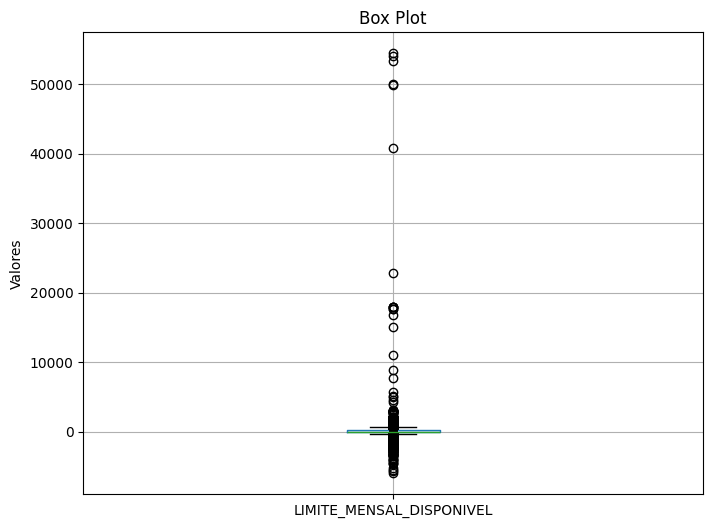

In [ ]:
# boxplot
df_cad_pandas.boxplot(column=coluna, figsize=(8, 6))
plot.title('Box Plot')
plot.ylabel('Valores')
plot.show()

In [ ]:
# Identificando outiliers

quantis = df_cad_new.approxQuantile(coluna, [0.25, 0.75], 0.0)
Q1, Q3 = quantis
IQR = Q3 - Q1

LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR

outliers = df_cad_new.filter((col(coluna) < LI) | (col(coluna) > LS))
print("Outliers")
outliers.orderBy(coluna, ascending=False).count()

Outliers


47344

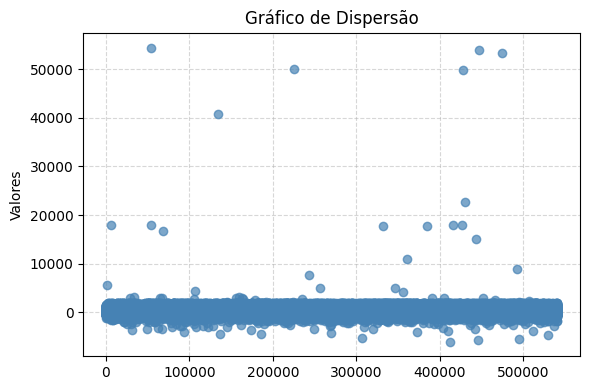

In [ ]:
# Gráfico de dispersão
df_plot = df_cad_new.select(coluna).dropna().toPandas()

plot.figure(figsize=(6, 4))
plot.plot(df_plot[coluna], 'o', color='steelblue', alpha=0.7)
plot.ylabel("Valores")
plot.title("Gráfico de Dispersão")
plot.grid(True, linestyle='--', alpha=0.5)
plot.tight_layout()
plot.show()